# WW domain notebook. 
The WW domain is a short binding domain targeting proline-rich motifs. WW domains are usually classified into 4 types, according to their binding specificity toward different motifs (e.g. PPXY, PPLP p[T/S]P...). We show here some features found by the algorithm.

## Loading data and packages

0
1000
2000
3000
4000
5000
6000
7000


/Users/jerometubiana/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


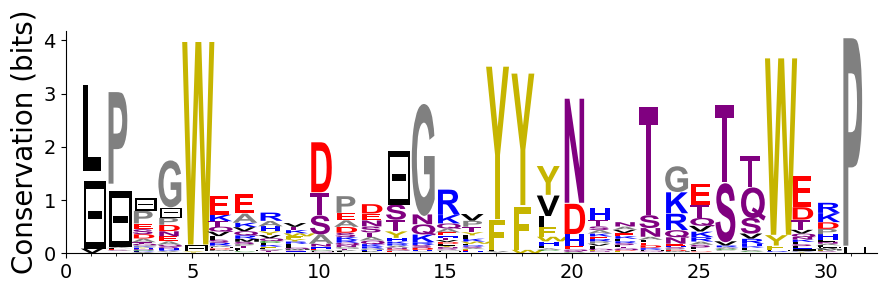

In [1]:
%matplotlib inline
import sys,os,pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('RBM/')
sys.path.append('utilities/')

try:
    import rbm
except:
    print 'Compiling cy_utilities first' # the RBM package contains cython files that must be compiled first.
    curr_dir = os.getcwd()
    os.chdir('RBM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    import rbm


import Proteins_utils, Proteins_RBM_utils, utilities,sequence_logo, plots_utils






filename = 'WW_domain_MSA.fasta'
path = u'data/WW/'

all_data = Proteins_utils.load_FASTA(path+filename,drop_duplicates=True)

seed = utilities.check_random_state(0) 
permutation = np.argsort(seed.rand(all_data.shape[0]))
all_data = all_data[permutation] # Shuffle data.

num_neighbours= Proteins_utils.count_neighbours(all_data)
all_weights = 1.0/num_neighbours


mu = utilities.average(all_data,c=21,weights=all_weights)

sequence_logo.Sequence_logo(mu,ticks_every=5);


# Training

In [2]:
make_training = False

n_v = 31 # Number of visible units; = # sites in alignment.
n_h = 100 # Number of hidden units.
visible = 'Potts' # Nature of visible units potential. Here, Potts states...
n_cv = 21 # With n_cv = 21 colors (all possible amino acids + gap)
hidden = 'dReLU' # Nature of hidden units potential. Here, dReLU potential.
seed = 0 # Random seed (optional)

if make_training: # Make full training.
    RBM = rbm.RBM(visible = visible,hidden = hidden,n_v = n_v,n_h = n_h, n_cv = n_cv, random_state = seed)
    batch_size = 100 # Size of mini-batches (and number of Markov chains used). Default: 100. Value for RBM shown in paper: 300
    n_iter = 2000 # Number of epochs. Value for RBM shown in paper: 6000
    learning_rate = 0.1 # Initial learning rate (default: 0.1). Value for RBM shown in paper: 0.1
    decay_after = 0.25 # Decay learning rate after 50% of iterations (default: 0.5). Value for RBM shown in paper: 0.5
    l1b = 0.25 # L1b regularization. Default : 0. Value for RBM shown in paper: 0.25
    N_MC = 1 # Number of Monte Carlo steps between each update. Value for RBM shown in paper: 10

    RBM.fit(all_data, weights= all_weights, batch_size = batch_size,
        n_iter = n_iter, l1b = l1b, N_MC = N_MC, 
       decay_after = decay_after, verbose = 0 )
else:
    RBM = Proteins_RBM_utils.loadRBM('models/RBM_WW_Domain.data') ## Alternative: Load previous model.
    
    

## Evaluate accuracy of training: Train and test set likelihood

In [3]:
RBM.AIS(n_betas=20000,verbose=1) # Compute partition function with annealed importance sampling
print utilities.average(RBM.likelihood(all_data), weights=all_weights)/31


Learning betas...
Elapsed time: 7.42919492722, Acceptance rates: [0.55252321 0.56071173 0.55981804 0.54694734 0.57005729 0.5748978
 0.55320173 0.57432629 0.54286085 0.56596081]
Initial evaluation: log(Z) = [659.02128482]
Iteration 2000, beta: 0.07973613554012882
Current evaluation: log(Z)= 677.3189752982007 +- 0.005321172902170726
Iteration 4000, beta: 0.15439613590782417
Current evaluation: log(Z)= 695.0516705338275 +- 0.007095053143846654
Iteration 6000, beta: 0.22662094679340317
Current evaluation: log(Z)= 712.604167977305 +- 0.008259867730688968
Iteration 8000, beta: 0.2967442798447781
Current evaluation: log(Z)= 729.9686415417784 +- 0.010481154293899415
Iteration 10000, beta: 0.4253768048017983
Current evaluation: log(Z)= 762.5193614424045 +- 0.009079783240286958
Iteration 12000, beta: 0.5331614286152304
Current evaluation: log(Z)= 790.4391147334753 +- 0.0072774380698234125
Iteration 14000, beta: 0.6591802607713246
Current evaluation: log(Z)= 823.7636276748505 +- 0.003355737956701

## Visualizing hidden units: Sequence logo of weights
Show sequence logos of some selected weights. Here, features reflect the structural constraint, as well as phylogenic diversity.


- Feature 1: The contact 4-22, realized either by Tiny-Negative or Negative-Positive amino-acids.
- Feature 2: An extended contact, between sites belonging to two strands.
- Feature 3: The pattern of substitutions observed after the substitution of the W28 site, one of the two sites that binds to the ligand.
- Feature 4: A feature localized around the binding pocket. It distinguishes between type-I and type-II protein specificities, see below.
- Feature 5: A feature localized on the beta1-beta2 loop. It distinguishes between long (with the gap) and short (without) loops, and is related to Type-IV specificity.

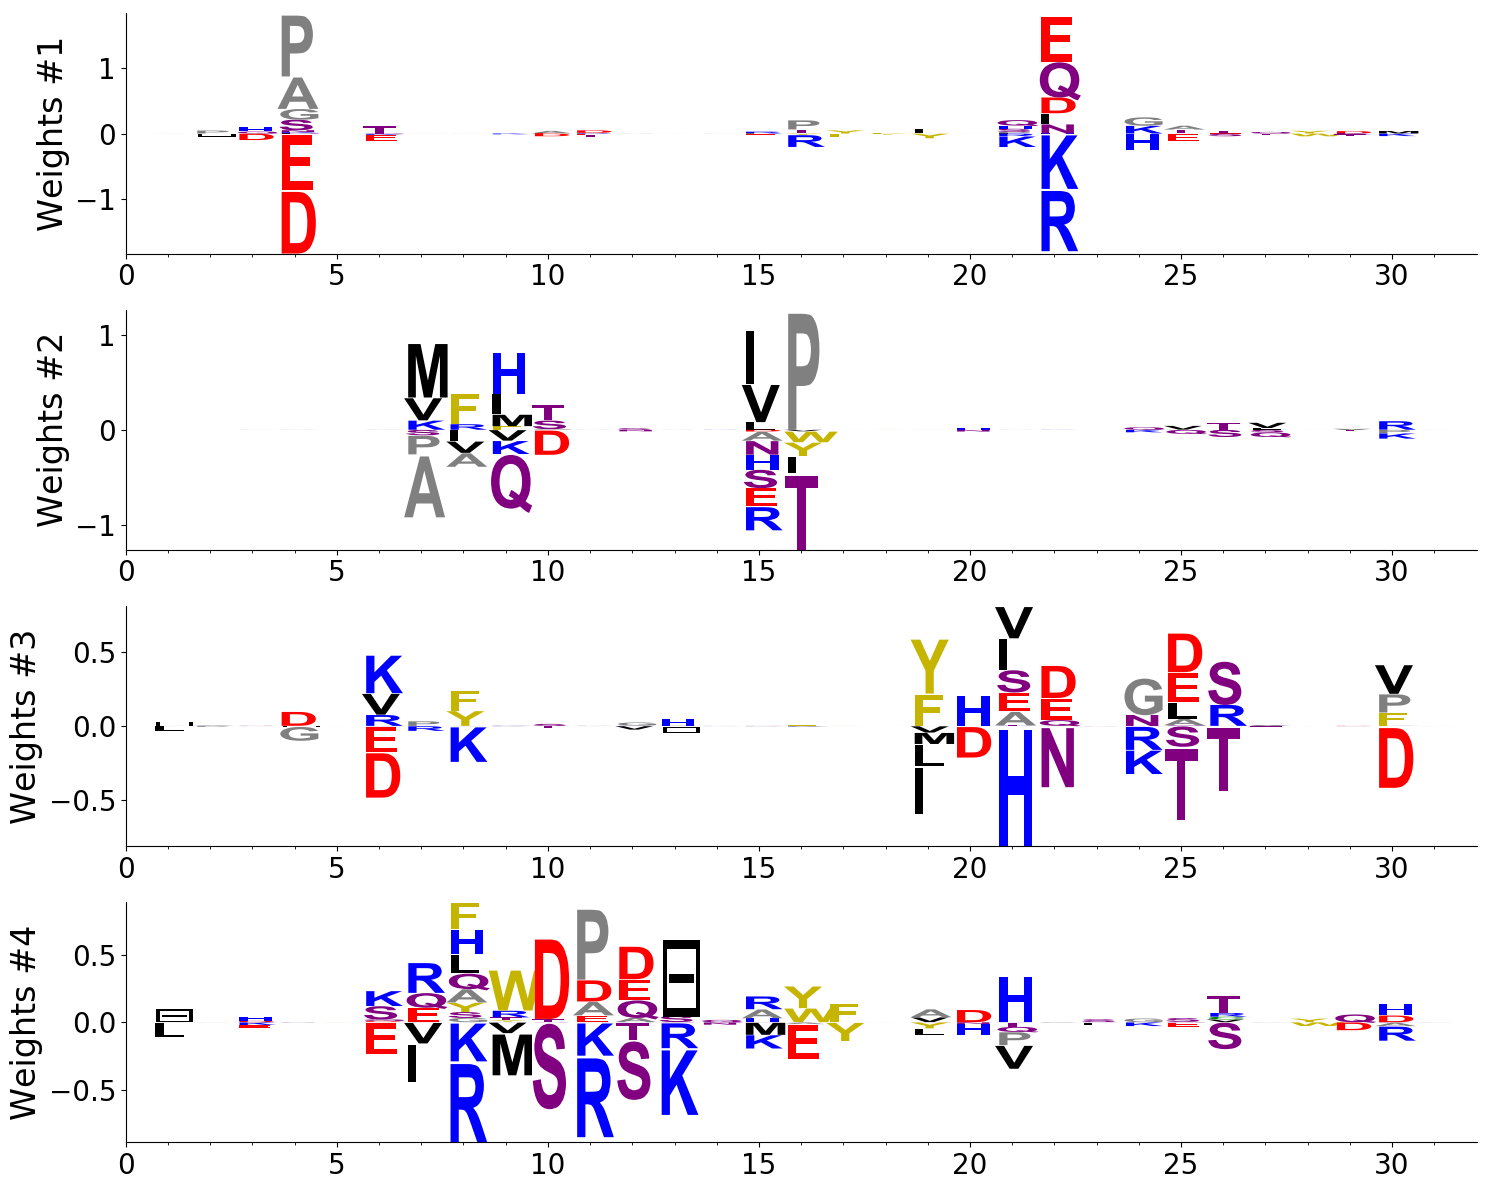

In [4]:
## Show some interesting features.

if make_training:
    interesting_features =  [39,34,13,93] # After training.
else:
    beta = Proteins_RBM_utils.get_beta(RBM.weights)
    order = np.argsort(beta)[::-1]
    interesting_features = order[[1,6,54,11]] # If loading trained RBM.



nsites = len(interesting_features)
fig = sequence_logo.Sequence_logo_multiple(RBM.weights[interesting_features], figsize=(15,3) ,ticks_every=5,ticks_labels_size=20,title_size=24);


## Visualizing hidden units: Distribution of inputs and non-linearity.
Protein sequences cluster according to the projections onto the weights.

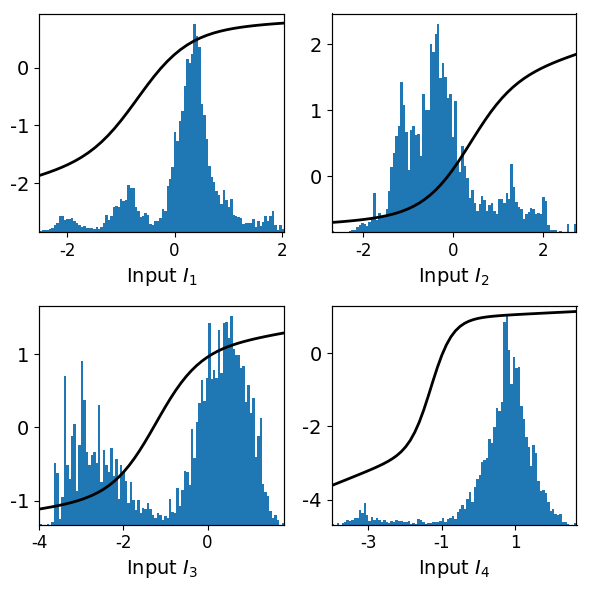

In [5]:
reload(plots_utils)
I = RBM.input_hiddens(all_data) # compute hidden unit input.
# Show inputs histogram and conditional means
plots_utils.plot_input_mean(RBM,I, interesting_features,ncols=2); 

## Visualizing hidden units: Phylogenic activity.
Are the features active across all, or only a portion of the phylogenic tree ? To assess this, we pick for each hidden unit the 20 sequences with highest $I_\mu$ (or lowest, depending on the sign of the non-linearity), and compute the distances between each pair. We compare to the background distribution of pairwise distances

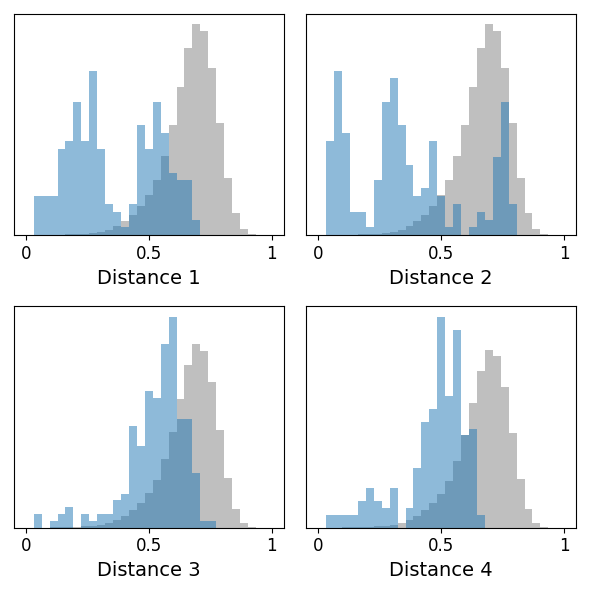

In [6]:
# Compute histogram of distances between top-activating sequences.
plots_utils.plot_top_activating_distance(RBM, I,all_data,interesting_features,ncols=2);

## Script for visualizing all hidden units into a single PDF. 
Requires  pdfjoin

In [ ]:
# Make all the previous plots, for all hidden units into a same pdf. Requires the utility pdfjoin.
reload(plots_utils)
plots_utils.make_all_weights(RBM,all_data,nweights = 10, weights=None,name = 'all_weights_WW.pdf',figsize=(15,3),sort='beta',dpi=200);

# Classification into specificites
Hidden units 4 and 5 partition the family into 3 clusters, that identify with the specificity-based classification. 

The YAP1 WW domain (blue cross) is of Type I, but mutations that bring it toward the Type II cluster (orange crosses) improve its activity on Type II ligands.

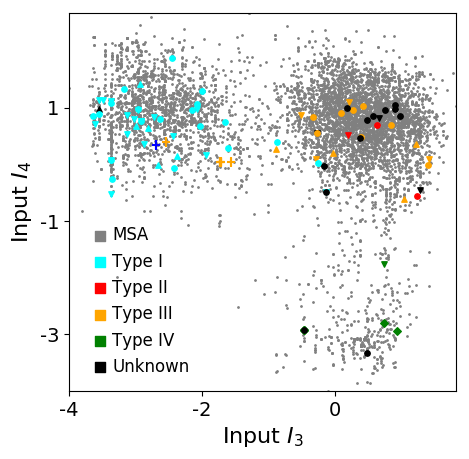

In [7]:
## Visualize specificities.


env = pickle.load(open(path+'WW_test_sequences.data','r'))
for key,item in env.items():
    globals()[key] = item
    

I  = RBM.input_hiddens(all_data)
I1 = RBM.input_hiddens(sequences_1)
I2 = RBM.input_hiddens(sequences_2)
I3 = RBM.input_hiddens(sequences_3)
I4 = RBM.input_hiddens(sequences_4)
Iu = RBM.input_hiddens(sequences_unknown)


I_yap = RBM.input_hiddens(sequence_yap_paper)
I_yap_mutated = RBM.input_hiddens(sequence_yap_paper_mutated)


#%%

#colors = ['black','cyan','red','orange', 'magenta','grey']
colors = ['grey','cyan','red','orange', 'green','black']


markers = ['v','^','D','o','+']
s1 = 1.0
s2 = 15.0
N = 2
fig, ax = plt.subplots()
fig.set_figwidth(5)
fig.set_figheight(5)


ix = interesting_features[2]
iy = interesting_features[3]
ax.scatter(I[:,ix],I[:,iy],c=colors[0],s=s1)    
for origin in [1,2,3,4]:
    ax.scatter(I1[(origin_seq1==origin) & ~((I1 == I_yap).min(1) ),ix],I1[(origin_seq1==origin) & ~((I1 == I_yap).min(1) ),iy],c=colors[1],s=s2,marker=markers[origin-1])
    ax.scatter(I2[origin_seq2==origin,ix],I2[origin_seq2==origin,iy],c=colors[2],s=s2,marker=markers[origin-1])
    ax.scatter(I3[origin_seq3==origin,ix],I3[origin_seq3==origin,iy],c=colors[3],s=s2,marker=markers[origin-1])
    ax.scatter(I4[origin_seq4==origin,ix],I4[origin_seq4==origin,iy],c=colors[4],s=s2,marker=markers[origin-1])
    ax.scatter(Iu[origin_sequ==origin,ix],Iu[origin_sequ==origin,iy],c=colors[5],s=s2,marker=markers[origin-1])
ax.scatter(I_yap[:,ix],I_yap[:,iy],c='blue',s=30,marker=markers[-1])
ax.scatter(I_yap_mutated[:,ix],I_yap_mutated[:,iy],c=colors[3],s=30,marker=markers[-1])
ax.scatter(I_yap[:,ix],I_yap[:,iy],c='blue',s=60,marker='|')
ax.scatter(I_yap_mutated[:,ix],I_yap_mutated[:,iy],c=colors[3],s=60,marker='|')

ax.scatter([],[],c=colors[0],s=s2,label='MSA',marker='s')
ax.scatter([],[],c=colors[1],s=s2,label='Type I',marker='s')
ax.scatter([],[],c=colors[2],s=s2,label='Type II',marker='s')
ax.scatter([],[],c=colors[3],s=s2,label='Type III',marker='s')
ax.scatter([],[],c=colors[4],s=s2,label='Type IV',marker='s')
ax.scatter([],[],c=colors[5],s=s2,label='Unknown',marker='s')

xmin = I[:,ix].min()
xmax = I[:,ix].max()
ax.set_xlim([xmin,xmax])
step = int( (xmax-xmin )/4.0) +1
xticks = np.arange(int(xmin), int(xmax)+1, step)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize=14)


ymin = I[:,iy].min()
ymax = I[:,iy].max()
ax.set_ylim([ymin,ymax])
step = int( (ymax-ymin )/4.0) +1
yticks = np.arange(int(ymin), int(ymax)+1, step)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks,fontsize=14)    

ax.set_xlabel('Input $I_3$',fontsize=16)
ax.set_ylabel('Input $I_4$',fontsize=16)

plt.legend(ncol=1,fontsize=12,frameon=False,handletextpad=-0.3,markerscale=2)




## Sampling from trained RBM.
Combining low-temperature sampling (with the duplicate RBM trick)  and conditional sampling allows to generate high-quality sequences with prescribed combinations of features, including ones that are unseen in the MSA. Here we generate sequences with 4 possible combinations of feature 4 and 5, corresponding to Type I, Type II/II, Type IV and an unknown specificity

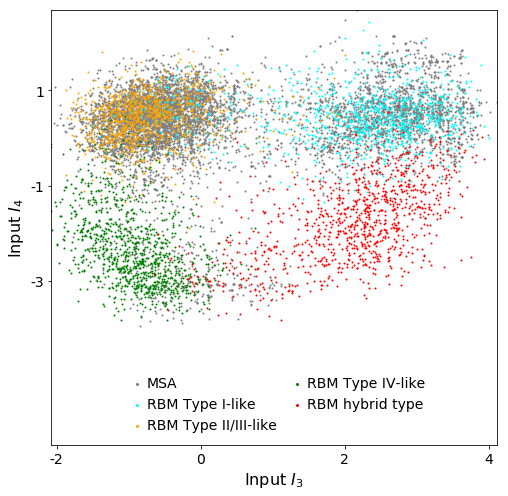

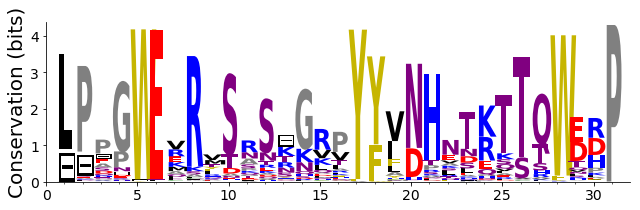

In [18]:
### Conditional Sampling: Generate sequences with prescribed combinations of features 2 and 5, including unseen combinations.




h = RBM.mean_hiddens(all_data)

val_neg = np.zeros(2)
val_pos = np.zeros(2)

i = interesting_features[2]
j = interesting_features[3]

histo =np.histogram(h[:,i],bins=100,weights=all_weights);
count = histo[0]
interval = (histo[1][:-1]+histo[1][1:])/2
val_neg[0] =  interval[interval<0][np.argmax(count[interval<0])]
val_pos[0] =  interval[interval>0][np.argmax(count[interval>0])]


histo =np.histogram(h[:,j],bins=100,weights=all_weights);
count = histo[0]
interval = (histo[1][:-1]+histo[1][1:])/2
val_neg[1] =  interval[interval<0][np.argmax(count[interval<0])]
val_pos[1] =  interval[interval>0][np.argmax(count[interval>0])]

    
# Define conditions, as a list of tuples (index, value)

cond3 = [(i,val_neg[0]), (j,val_pos[1]) ]
cond4 = [(i,val_pos[0]), (j,val_pos[1]) ]


if make_training:
    cond1 = [(i,val_neg[0] *3), (j,val_neg[1] ) ]         
    cond2 = [(i,val_pos[0]*2), (j,val_neg[1]) ]

else:
    cond1 = [(i,val_neg[0] *2), (j,val_neg[1] ) ]         
    cond2 = [(i,val_pos[0] * 3), (j,val_neg[1]) ]


# Build new conditional RBMs, with M-2 hidden units.
condRBM1 = Proteins_RBM_utils.conditioned_RBM(RBM,cond1)
condRBM2 = Proteins_RBM_utils.conditioned_RBM(RBM,cond2)
condRBM3 = Proteins_RBM_utils.conditioned_RBM(RBM,cond3)
condRBM4 = Proteins_RBM_utils.conditioned_RBM(RBM,cond4)


# Generate sequences.
N_sequences = 1000
N_PT = 1
Nstep = 10


datav1,datah1 = condRBM1.gen_data(Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,N_PT=N_PT,update_betas=False,Nthermalize=500)
datav2,datah2 = condRBM2.gen_data(Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,N_PT=N_PT,update_betas=False,Nthermalize=500)
datav3,datah3 = condRBM3.gen_data(Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,N_PT=N_PT,update_betas=False,Nthermalize=500)
datav4,datah4 = condRBM4.gen_data(Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,N_PT=N_PT,update_betas=False,Nthermalize=500)
   

    
    
if make_training:
    data_type_1 = datav4
    data_type_23 = datav3
    data_type_4 = datav1
    data_type_unknown = datav2 # Unseen combination in data
    
else:
    data_type_1 = datav3
    data_type_23 = datav4    
    data_type_4 = datav2
    data_type_unknown = datav1 # Unseen combination in data
    
    
if make_training:
    datav_type_1_lowT, datah_type_1_lowT = Proteins_RBM_utils.gen_data_lowT(condRBM3, beta=2,Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,N_PT=N_PT,update_betas=False,Nthermalize=500)
    datav_type_unknown_lowT, datah_type_unknown_lowT = Proteins_RBM_utils.gen_data_lowT(condRBM1, beta=2,Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,N_PT=N_PT,update_betas=False,Nthermalize=500)    
else:
    datav_type_1_lowT, datah_type_1_lowT = Proteins_RBM_utils.gen_data_lowT(condRBM4, beta=2,Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,N_PT=N_PT,update_betas=False,Nthermalize=500)
    datav_type_unknown_lowT, datah_type_unknown_lowT = Proteins_RBM_utils.gen_data_lowT(condRBM2, beta=2,Nchains = 100, Lchains = N_sequences/100,Nstep=Nstep,N_PT=N_PT,update_betas=False,Nthermalize=500)    


I = RBM.input_hiddens(all_data)
I_type_1 = RBM.input_hiddens(data_type_1)
I_type_23 = RBM.input_hiddens(data_type_23)
I_type_4 = RBM.input_hiddens(data_type_4)
I_type_unknown = RBM.input_hiddens(data_type_unknown)
I_type_1_lowT = RBM.input_hiddens(datav_type_1_lowT)
I_type_unknown_lowT = RBM.input_hiddens(datav_type_unknown_lowT)






#%%
s1 = 1.0
s2 = 1.0

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
ax.scatter(I[:,i], I[:,j],c='gray',s=s1,label='MSA')
ax.scatter(I_type_1[:,i], I_type_1[:,j],c='cyan',s=s2,label='RBM Type I-like')
ax.scatter(I_type_23[:,i], I_type_23[:,j],c='orange',s=s2,label = 'RBM Type II/III-like')
ax.scatter(I_type_4[:,i], I_type_4[:,j],c='green',s=s2,label='RBM Type IV-like')
ax.scatter(I_type_unknown[:,i], I_type_unknown[:,j],c='red',s=s2,label='RBM hybrid type')
plt.xlabel('Input $I_3$',fontsize=16)
plt.ylabel('Input $I_4$',fontsize=16)
xmin = I[:,i].min()
xmax = I[:,i].max()
ax.set_xlim([xmin,xmax])
step = int( (xmax-xmin )/4.0) +1
xticks = np.arange(int(xmin), int(xmax)+1, step)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize=14)

ymin = I[:,j].min()
ymax = I[:,j].max()
ax.set_ylim([ymin -2.5,ymax])
step = int( (ymax-ymin )/4.0) +1
yticks = np.arange(int(ymin), int(ymax)+1, step)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks,fontsize=14) 
plt.legend(ncol=2,fontsize=14,frameon=False,handletextpad=-0.3,markerscale=2,loc='lower center',columnspacing=0.5)
fig.show()


mu = utilities.average(data_type_unknown,c=21)
fig = sequence_logo.Sequence_logo(mu,ticks_every=5);

## Proximity with sequences from the alignment.
A good generative model should produce sequences that are reasonibly far away from the training set. Conversely, sequences that are too far away should have low likelihood and a trade-off exists.

For each generated sequence, we compute its likelihood and distance to the closest natural sequence.




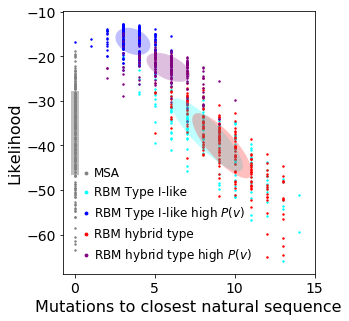

In [19]:
# ## Visualize likelihood vs distance to closest sequence.

from matplotlib import patches

def distance_to_natural(synth_seq,nat_seq): # For each seq in synth_seq, compute the distance to the closest natural sequence 
    min_dists = []
    for seq in synth_seq:
        min_dists.append ((seq[np.newaxis,:] <> nat_seq).mean(1).min() )
    return np.array(min_dists)



nmax = 200
N = 31

subset_nat = np.argsort(np.random.rand(all_data.shape[0]))[:nmax]
subset_synth = np.argsort(np.random.rand(data_type_1.shape[0]))[:nmax]


d_type_1 = distance_to_natural(data_type_1,all_data)
d_type_1_lowT = distance_to_natural(datav_type_1_lowT,all_data)
d_type_unknown = distance_to_natural(data_type_unknown,all_data)
d_type_unknown_lowT = distance_to_natural(datav_type_unknown_lowT,all_data)


lik_nat = RBM.likelihood(all_data)
lik_type_1 = RBM.likelihood(data_type_1)
lik_type_1_lowT = RBM.likelihood(datav_type_1_lowT)
lik_type_unknown = RBM.likelihood(data_type_unknown)
lik_type_unknown_lowT = RBM.likelihood(datav_type_unknown_lowT)


s1 = 14
s2 = 16
s3 = 2
s4 =12


off = 0.15

fig , ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(5)
fig.subplots_adjust(left=0.2,bottom=0.15)
plt.scatter(np.zeros(nmax), lik_nat[subset_nat], marker='o', s = s3, c = 'gray',label='MSA');
plt.scatter(d_type_1[subset_synth]*N, lik_type_1[subset_synth], marker='o', s = s3, c = 'cyan',label='RBM Type I-like')
plt.scatter(d_type_1_lowT[subset_synth]*N, lik_type_1_lowT[subset_synth], marker='o', s = s3, c = 'blue',label=r'RBM Type I-like high $P(v)$')
plt.scatter(d_type_unknown[subset_synth]*N, lik_type_unknown[subset_synth], marker='o', s = s3, c = 'red',label=r'RBM hybrid type');
plt.scatter(d_type_unknown_lowT[subset_synth]*N, lik_type_unknown_lowT[subset_synth], marker='o', s = s3, c = 'purple',label=r'RBM hybrid type high $P(v)$');



mu = lik_nat.mean()
std = lik_nat.std()
w = 0.5

rec = patches.Rectangle(xy=(-w/2, mu-std),
              width=w, height=2*std)
rec.set_facecolor('gray')
rec.set_alpha(0.5)
ax.add_artist(rec)


mu_dists = (d_type_1*N).mean()
mu_lik = lik_type_1.mean()
covariance = np.cov(d_type_1*N,  lik_type_1 )

lam,v = np.linalg.eigh(covariance)

ell = patches.Ellipse(xy=(mu_dists, mu_lik),
              width=np.sqrt(lam)[0]*2, height=np.sqrt(lam)[1]*2,
              angle=np.rad2deg(-np.arccos(v[0, 0])))
ell.set_facecolor('cyan')
ell.set_alpha(0.25)
ax.add_artist(ell)

mu_dists = (d_type_1_lowT*N).mean()
mu_lik = lik_type_1_lowT.mean()
covariance = np.cov(d_type_1_lowT*N,  lik_type_1_lowT )

lam,v = np.linalg.eigh(covariance)

ell = patches.Ellipse(xy=(mu_dists, mu_lik),
              width=np.sqrt(lam)[0]*2, height=np.sqrt(lam)[1]*2,
              angle=np.rad2deg(-np.arccos(v[0, 0])))
ell.set_facecolor('blue')
ell.set_alpha(0.25)
ax.add_artist(ell)

mu_dists = (d_type_unknown*N).mean()
mu_lik = lik_type_unknown.mean()
covariance = np.cov(d_type_unknown*N,  lik_type_unknown )

lam,v = np.linalg.eigh(covariance)

ell = patches.Ellipse(xy=(mu_dists, mu_lik),
              width=np.sqrt(lam)[0]*2, height=np.sqrt(lam)[1]*2,
              angle=np.rad2deg(-np.arccos(v[0, 0])))
ell.set_facecolor('red')
ell.set_alpha(0.25)
ax.add_artist(ell)


mu_dists = (d_type_unknown_lowT*N).mean()
mu_lik = lik_type_unknown_lowT.mean()
covariance = np.cov(d_type_unknown_lowT*N,  lik_type_unknown_lowT )

lam,v = np.linalg.eigh(covariance)

ell = patches.Ellipse(xy=(mu_dists, mu_lik),
              width=np.sqrt(lam)[0]*2, height=np.sqrt(lam)[1]*2,
              angle=np.rad2deg(-np.arccos(v[0, 0])))
ell.set_facecolor('purple')
ell.set_alpha(0.25)
ax.add_artist(ell)

x = [0,5,10,15]
ax.set_xticks(x)
ax.set_xticklabels(x,fontsize=s1);
ax.set_xlabel('Mutations to closest natural sequence',fontsize=s2)
ax.set_ylabel('Likelihood',fontsize=s2)


for tl in ax.get_xticklabels():
    tl.set_fontsize(s1)
for tl in ax.get_yticklabels():
    tl.set_fontsize(s1)    
plt.legend(fontsize=s4,frameon=False,loc='lower left',markerscale=2,handletextpad=-0.3)


